## Set-up

In [88]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px

import numpy as np
from tqdm.notebook import trange

sns.set_theme()
colors = sns.color_palette("deep")

from utils import geometric_median, geometric_medoid, month_to_season
from NMF_iter import normalize_curves, functional_norm
from itertools import permutations

# HOTFIX Parse IMCEI
import locale
locale.setlocale(locale.LC_ALL, 'it_IT')

'it_IT'

In [89]:
def plot_components(H, ax=None, figsize=(10, 6), title='Components found by the NMF', component_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    abscissa = np.linspace(0, 24, H.shape[1])
    for k in range(n_components):
        if component_names is not None:
            label = component_names[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(abscissa, H[k, :], marker='o', linestyle='-', label=label)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(title)
    ax.legend()
    
    return fig, ax

In [90]:
def initialize_W(X, n_components):
    W = pd.DataFrame(np.random.rand(len(X), n_components), index=X.index, columns=[f"Component {k+1}" for k in range(n_components)])
    W = W.div(W.sum(axis=1), axis=0)
    return W

In [91]:
def align_components(H_results, W_results, ref_idx=0):
    # Align the components
    n_comp, n_eval_points, n_runs = H_results.shape
    ref_H = H_results[..., ref_idx]

    for n in range(1, n_runs):

        best_permutation = list(range(n_comp))
        eval_points = np.arange(0, n_eval_points, int(n_eval_points / 24))
        best_alignment = np.linalg.norm(ref_H - H_results[..., n][range(n_comp), :], 'fro')

        for permutation in list(permutations(range(n_comp))):
            alignment = np.linalg.norm(ref_H - H_results[..., n][list(permutation)[:n_comp], :], 'fro')

            if alignment < best_alignment:
                best_alignment = alignment
                best_permutation = list(permutation)

        H_results[..., n] = H_results[..., n][best_permutation, :]
        W_results[..., n] = W_results[..., n][:, best_permutation]

In [117]:
n_components = 3 # Number of components for the matrix factorization
n_runs = 1000
smoothed = False
specific = '_Italy_Spring-Fall'

colormap = ListedColormap([colors[k] for k in range(n_components)])

region_order = [
    'North',
    'Centre.North',
    'Sardinia',
    'Centre.South',
    'South',
    'Calabria',
    'Sicily'
]

daytype_order = [
    'Monday',
    'Working day',
    'Saturday',
    'Holiday'
]

# Process data

## Data matrix $X$

In [118]:
if smoothed:
    infile = 'data/daily_curves_pos_smoothed_13b_15min.csv'
else:
    infile = f'data/2_processed/daily_curves{specific}.csv'
input_df = pd.read_csv(infile, index_col=0)
print(len(input_df))
input_df.head(3)

1098


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
2018-03-01_Working day,34246.000,31915.001,30464.000,29773.000,29594.999,30913.000,35167.001,41400.000,47893.999,52811.000,...,51805.0,51608.000,51168.000,52064.001,52974.000,49401.0,45799.0,40692.001,36404.0,32706.000
2018-03-02_Working day,32706.000,30108.000,29035.001,28689.001,28796.001,29998.002,34075.001,40530.000,47629.001,51680.999,...,48600.0,48069.000,47721.001,49102.999,50628.000,47528.0,43948.0,39604.001,35672.0,32324.999
2018-03-03_Saturday,32324.999,29646.999,28336.000,27548.999,27292.001,27747.000,29529.000,32051.999,36790.000,40970.000,...,36872.0,36245.999,37054.001,39873.000,42613.001,40538.0,37168.0,34272.000,31409.0,29063.000


In [119]:
# HOTFIX for single-zone case
zone = 'Italy'
input_df.index = zone + '_' + input_df.index

unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
# df = df[df.month.isin(months)]
# df = df[(df.month == '10')&(df.daytype=='Working day')]
print(len(df))
df.head(3)

1098


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,region,year,month,daytype
Italy_2018-03-01_Working day,34246.000,31915.001,30464.000,29773.000,29594.999,30913.000,35167.001,41400.000,47893.999,52811.000,...,52974.000,49401.0,45799.0,40692.001,36404.0,32706.000,Italy,2018,03,Working day
Italy_2018-03-02_Working day,32706.000,30108.000,29035.001,28689.001,28796.001,29998.002,34075.001,40530.000,47629.001,51680.999,...,50628.000,47528.0,43948.0,39604.001,35672.0,32324.999,Italy,2018,03,Working day
Italy_2018-03-03_Saturday,32324.999,29646.999,28336.000,27548.999,27292.001,27747.000,29529.000,32051.999,36790.000,40970.000,...,42613.001,40538.0,37168.0,34272.000,31409.0,29063.000,Italy,2018,03,Saturday


In [120]:
X = df.drop(unit_info.columns, axis=1)
X = normalize_curves(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Italy_2018-03-01_Working day,0.032357,0.030154,0.028783,0.028130,0.027962,0.029207,0.033227,0.039116,0.045252,0.049897,...,0.048947,0.048761,0.048345,0.049191,0.050051,0.046675,0.043272,0.038447,0.034395,0.030902
Italy_2018-03-02_Working day,0.032165,0.029610,0.028555,0.028215,0.028320,0.029502,0.033511,0.039860,0.046841,0.050826,...,0.047796,0.047274,0.046932,0.048291,0.049791,0.046742,0.043221,0.038949,0.035082,0.031790
Italy_2018-03-03_Saturday,0.038047,0.034895,0.033352,0.032426,0.032123,0.032659,0.034756,0.037726,0.043303,0.048223,...,0.043399,0.042662,0.043613,0.046931,0.050156,0.047714,0.043747,0.040339,0.036969,0.034208
Italy_2018-03-04_Holiday,0.039825,0.036418,0.034440,0.033852,0.033716,0.034062,0.035491,0.035902,0.039292,0.042487,...,0.042020,0.042054,0.043243,0.048251,0.052015,0.051138,0.048463,0.045898,0.041882,0.038266
Italy_2018-03-05_Monday,0.028692,0.026621,0.025917,0.025228,0.025544,0.027101,0.032048,0.038521,0.046417,0.051172,...,0.050026,0.050199,0.049727,0.049832,0.051000,0.048104,0.044646,0.039688,0.035603,0.031875


## NMF

In [121]:
p = len(X.columns)

In [122]:
# Load the arrays from the .npz file
if smoothed:
    path = f'data/3_output/nmf_results/batch/{n_components}comp_smoothed_{n_runs}runs{specific}.npz'
else:  
    path = f'data/3_output/nmf_results/batch/{n_components}comp_{n_runs}runs{specific}.npz'
data = np.load(path)
print('Loaded ', path)

Loaded  data/3_output/nmf_results/batch/3comp_1000runs_Italy_Spring-Fall.npz


In [123]:
# Access the arrays
H_results = data['H_results']
W_results = data['W_results']
iterations = data['iterations']
errors = data['errors']

In [124]:
pd.Series(iterations).quantile(np.linspace(0,1,11))

0.0      20.0
0.1     890.0
0.2    2790.0
0.3    2947.0
0.4    3090.0
0.5    3220.0
0.6    3360.0
0.7    3540.0
0.8    3782.0
0.9    4100.0
1.0    9070.0
dtype: float64

In [125]:
# Remove results for which we have less than 100 iterations (they correspond to a local minima where all profile are the same)
H_results = H_results[..., iterations > 100]
W_results = W_results[..., iterations > 100]
errors = errors[iterations > 100]
iterations = iterations[iterations > 100]
print('{} results clean'.format(W_results.shape[2]))

951 results clean


In [126]:
# Align solutions to have comp x of solution i matching comp x of solution j
align_components(H_results, W_results, ref_idx=0)

In [127]:
n_clean_runs = W_results.shape[2]
abscissa = [float(x) for x in X.columns]

## Quick data check

Check-plots on the solutions found

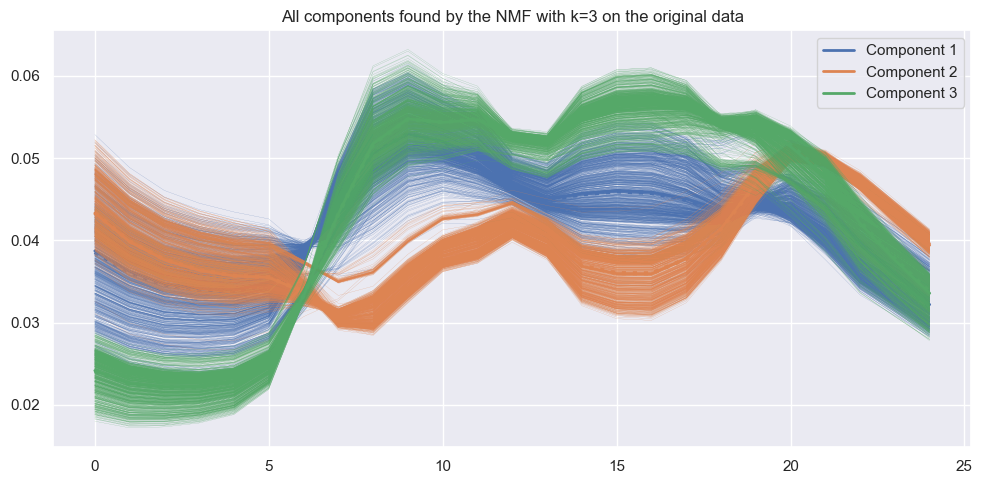

In [128]:
fig, ax = plt.subplots(figsize=(10, 5))

for k in range(n_components):
    for i in range(n_clean_runs):
        line, = ax.plot(abscissa, H_results[k, :, i], linewidth=0.1, color=colors[k])
    label = f'Component {k + 1}'
    ax.plot(abscissa, geometric_median(H_results[k, ...].T), linewidth=2, color=colors[k], label=label)
    ax.plot(abscissa, geometric_medoid(H_results[k, ...].T), linewidth=3, linestyle='dotted', color=colors[k])
ax.set_title(f"All components found by the NMF with k={n_components} on the {(1-smoothed)*'original' + smoothed*'smoothed'} data")
ax.legend()
plt.tight_layout()

Let's plot separately per component

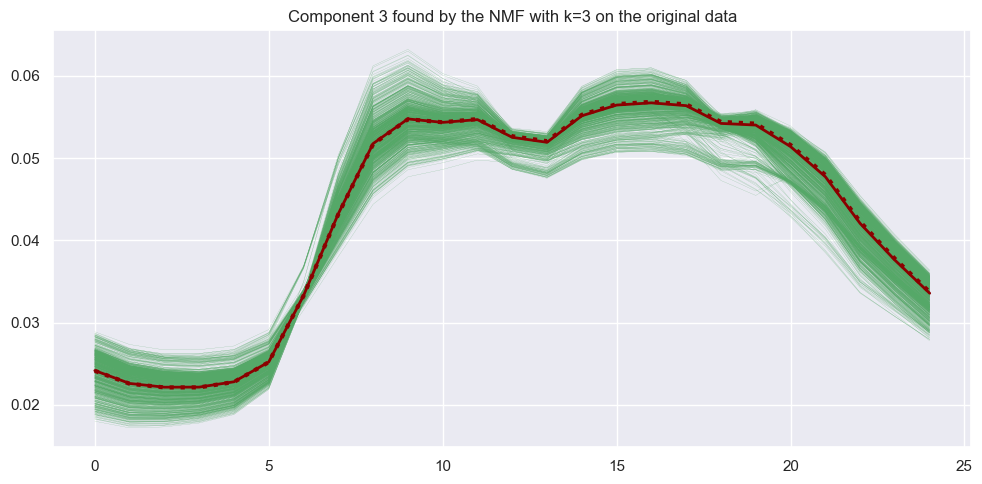

In [131]:
k = 2
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(n_clean_runs):
    line, = ax.plot(abscissa, H_results[k, :, i], linewidth=0.1, color=colors[k])
ax.plot(abscissa, geometric_median(H_results[k, ...].T), linewidth=2, color='darkred')
ax.plot(abscissa, geometric_medoid(H_results[k, ...].T), linewidth=3, linestyle='dotted', color='darkred')
ax.set_title(f"Component {k + 1} found by the NMF with k={n_components} on the {(1-smoothed)*'original' + smoothed*'smoothed'} data")
plt.tight_layout()

<Axes: >

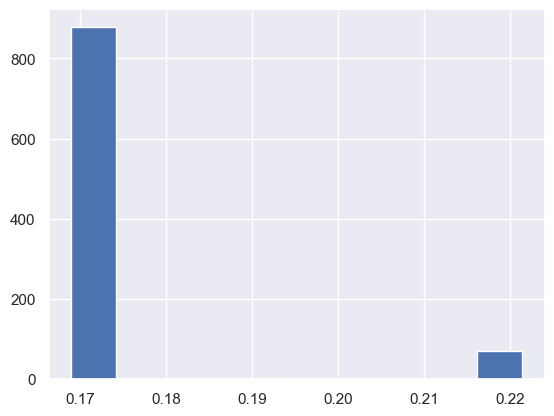

In [132]:
pd.Series(errors).hist()

# Selection of the optimal solution

## Based on modelling constraints

### Cyclic profiles

We want to find solutions for which
$$\text{discontinuity}(H) = \sum_{k=1}^K(H_k(p) - H_k(1))^2$$

In [133]:
H_discontinuity = ((H_results[:, 0, :] - H_results[:, p-1, :])**2).sum(axis=0)

<Axes: >

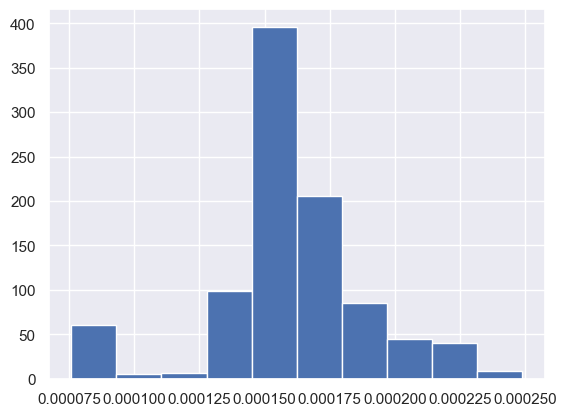

In [134]:
pd.Series(H_discontinuity).hist()

### Total distance of concentration vectors to simplex

The distance to the simplex of one observation $x$ to the simplex $\mathcal{S}(n)$ is the following
$$\text{dist}(x, \mathcal{S}(n)) = \inf_{\substack{y \in \mathcal{S}(n)}} d(x, y)$$

The point $y$ minimizing the distance is:
$$y = \frac{x}{||x||_1}$$

Here we will compute the sum of the distances to the simplex for all vector of concentrations of the matrix $W$

In [135]:
W_proj_simplex = W_results / W_results.sum(axis=1)[:, np.newaxis, :]
W_dist_simplex = np.sqrt(((W_results - W_proj_simplex)**2).sum(axis=1))
W_sum_dist_simplex = W_dist_simplex.sum(axis=0)

<Axes: >

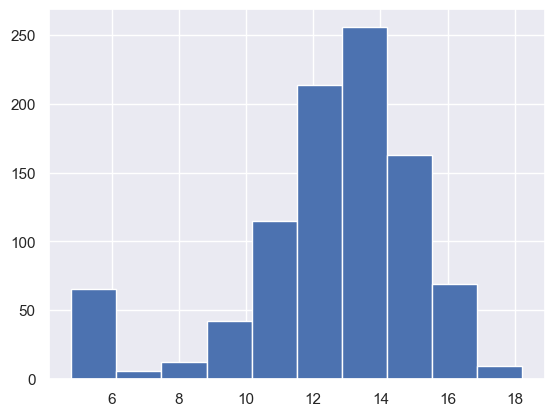

In [136]:
pd.Series(W_sum_dist_simplex).hist()

### Total distance of the components to the p-dimensional simplex

Similarly, the unit l1 norm constraint on the components, having necessarily positive coordinates, result in the components having to lie on the unit 1-sphere

In [137]:
H_proj_unit = np.empty_like(H_results)
for n in range(H_results.shape[2]):
    H_proj_unit[..., n] = normalize_curves(H_results[..., n])
H_dist_unit = np.sqrt(((H_results - H_proj_unit)**2).sum(axis=1))
H_sum_dist_unit = H_dist_unit.sum(axis=0)

<Axes: >

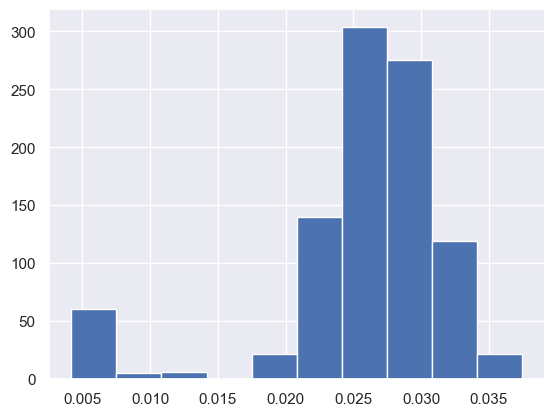

In [138]:
pd.Series(H_sum_dist_unit).hist()

## Based on compliance with consumption data

In [60]:
# subset_zones = ['North', 'Centre-North']
# subset_zones = ['South', 'Sardinia', 'Sicily', 'Calabria']
subset_zones = ['Centre-South']
# subset_zones = None

In [252]:
cons_df = pd.read_excel('data/1_input/consumption/consumption_chart.xlsx')
if subset_zones:
    cons_df = cons_df[cons_df.Zone.isin(subset_zones)]

# We put agricoltura sector in the industrial one
cons_df['Settore corretto'] = cons_df['Settore corretto'].replace('Agricoltura', 'Industria')
region_cons_df = pd.pivot_table(cons_df, values='Sum of Consumo corretto', index=['Zone', 'year'], columns='Settore corretto', aggfunc='sum')
region_cons_df.columns.name = None
region_cons_df = region_cons_df[['Servizi', 'Industria', 'Domestico']]

# Align with the consumption computed from the load data
uncorrected_total = region_cons_df[['Servizi', 'Industria', 'Domestico']].sum(axis=1).values
corrected_total = df.groupby(['region', 'year'])[[str(i) for i in range(24)]].sum().sum(axis=1).values / 1000
region_cons_df = region_cons_df.mul(corrected_total / uncorrected_total, axis=0)
region_cons_df

Servizi     Industria     Domestico
Zone         year                                          
Centre-South 2018  19976.347063  12700.311797  14017.064009
             2019  19772.016954  13631.094948  14293.373072
             2020  17218.840831  13536.204996  14545.866128
             2021  19770.418976  17714.659380  15937.164866
             2022  20853.271645  17615.761924  15786.516089

In [264]:
X_unnorm = df.drop(unit_info.columns, axis=1)
h = 24 / (X_unnorm.shape[1]-1)
norm_X = X_unnorm.apply(lambda row: functional_norm(row, h), axis=1, raw=True)

cons = np.zeros((len(region_cons_df), n_components, n_clean_runs))
dist_to_cons = np.zeros(n_clean_runs)

for i in trange(W_results.shape[-1]):

    W = W_results[..., i]
    H = H_results[..., i]

    day_cons = pd.DataFrame(W, index=norm_X.index).mul(norm_X, axis=0)
    day_cons['region'] = unit_info['region']
    day_cons['year'] = unit_info['year']
    best_year_cons = day_cons.groupby(['region', 'year']).sum() / 1000
    min_dist = abs(best_year_cons - region_cons_df.values).values.mean()
    best_permutation = list(range(n_components))

    for permutation in list(permutations(range(n_components))):
        year_cons = best_year_cons.iloc[:, list(permutation)]
        dist = abs(year_cons - region_cons_df.values).values.mean()
        if dist < min_dist:
            min_dist = dist
            best_permutation = list(permutation)
            best_year_cons = year_cons

    W_results[..., i] = W[:, best_permutation]
    H_results[..., i] = H[best_permutation, :]
    cons[..., i] = best_year_cons.values
    dist_to_cons[i] = min_dist


  0%|          | 0/7938 [00:00<?, ?it/s]

## Based on compliance with indexes

### Read indexes

In [61]:
imser = pd.read_excel('data/1_input/indicators/IMSER.xlsx')
imser = imser[imser.Mese.dt.year != 2023].set_index('Mese').rename({'IMSER (GWh)': 'IMSER'}, axis=1) # We don't have data for this year

imcei = pd.read_excel('data/1_input/indicators/IMCEI_mensile.xlsx')
imcei['Mese'] = pd.to_datetime(imcei['Anno'].astype(str) + '-' + imcei['Mese'], format='%Y-%b')
imcei = imcei.set_index('Mese').drop('Anno', axis=1).rename({'IMCEI Mensile': 'IMCEI'}, axis=1)

domestic = pd.read_excel('data/1_input/indicators/Domestico 2020 e 2021.xlsx', skiprows=12, usecols=range(3))
domestic = domestic.set_index('Mese').drop('Domestico kWh', axis=1)

indics = imcei.copy()
indics['IMSER'] = imser['IMSER']
indics['EniDom'] = domestic['Domestico GWh']
indics.head()

,IMCEI,IMSER,EniDom
Mese,,,
2018-01-01,101.876892,NaN,NaN
2018-02-01,104.070890,NaN,NaN
2018-03-01,112.023582,NaN,NaN
2018-04-01,102.915390,NaN,NaN
2018-05-01,113.072924,NaN,NaN


### Compute correlation coefficient

In [62]:
X_unnorm = df.drop(unit_info.columns, axis=1)
h = 24 / (X_unnorm.shape[1]-1)
norm_X = X_unnorm.apply(lambda row: functional_norm(row, h), axis=1, raw=True)

n_months = len(df[['year', 'month']].drop_duplicates())
cons_month = np.zeros((n_months, n_components, n_clean_runs))
corr_indic = np.zeros((n_clean_runs, n_components))

for i in trange(W_results.shape[-1]):

    W = W_results[..., i]
    H = H_results[..., i]

    day_cons = pd.DataFrame(W, index=norm_X.index).mul(norm_X, axis=0)
    day_cons['year'] = unit_info['year']
    day_cons['month'] = unit_info['month']
    day_cons['yearmonth'] = pd.to_datetime(day_cons['year'].astype(str) + '-' + day_cons['month'], format='%Y-%m')
    best_month_cons = day_cons.groupby('yearmonth')[[0, 1, 2]].sum() / 1000

    corr_imser = indics['IMSER'].corr(best_month_cons[0])
    corr_imcei = indics['IMCEI'].corr(best_month_cons[1])
    corr_enidom = indics['EniDom'].corr(best_month_cons[2])
    max_corr = (corr_imser + corr_imcei + corr_enidom) / 3
    
    best_permutation = list(range(n_components))

    for permutation in list(permutations(range(n_components)))[1:]: # Try permutation of the components in case of mis-alignment
        month_cons = best_month_cons.iloc[:, list(permutation)].rename(columns=dict(zip(list(permutation), best_permutation)))
        corr = (indics['IMSER'].corr(month_cons[0]) + indics['IMCEI'].corr(month_cons[1]) + indics['EniDom'].corr(month_cons[2])) / 3
        if corr > max_corr:
            max_corr = corr
            best_permutation = list(permutation)
            best_month_cons = month_cons
            # print(f'Had to permute {i}')

    W_results[..., i] = W[:, best_permutation]
    H_results[..., i] = H[best_permutation, :]
    cons_month[..., i] = best_month_cons.values
    corr_indic[i, :] = [corr_imser, corr_imcei, corr_enidom]

  0%|          | 0/975 [00:00<?, ?it/s]

In [29]:
corr_df = pd.DataFrame(corr_indic, columns=['IMSER', 'IMCEI', 'EniDom'])
corr_df

,IMSER,IMCEI,EniDom
0,0.530593,0.053668,-0.303832
1,0.574978,0.152342,-0.321686
2,0.527692,0.035761,-0.315607
3,0.575910,0.132471,-0.342188
4,0.479333,-0.166210,-0.110590
...,...,...,...
882,0.547339,0.131278,-0.355649
883,0.610396,0.319845,-0.473326
884,0.638851,0.489832,-0.553937
885,0.393768,-0.250312,-0.062775


<Axes: >

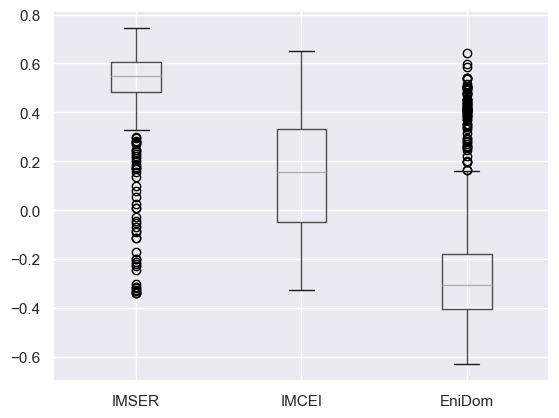

In [30]:
corr_df.boxplot()

array([[<Axes: title={'center': 'IMSER'}>,
        <Axes: title={'center': 'IMCEI'}>],
       [<Axes: title={'center': 'EniDom'}>, <Axes: >]], dtype=object)

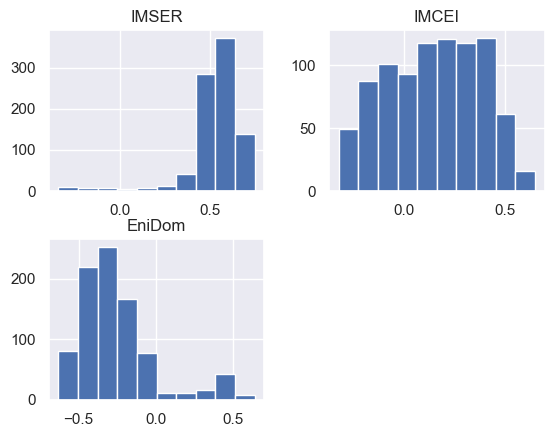

In [31]:
corr_df.hist()

In [32]:
criteria_df = pd.DataFrame({
    'dist_simplex': W_sum_dist_simplex,
    # 'dist_cons': dist_to_cons,
    'error': errors / int(X.shape[1] / 24),
    'corr_IMCEI': corr_df.IMCEI,
    'corr_IMSER': corr_df.IMSER,
    'corr_EnelDom': corr_df.EniDom,
    'mean_corr': corr_df.mean(axis=1)
})
criteria_df

,dist_simplex,error,corr_IMCEI,corr_IMSER,corr_EnelDom,mean_corr
0,22.445545,0.265078,0.053668,0.530593,-0.303832,0.093476
1,18.397422,0.264601,0.152342,0.574978,-0.321686,0.135211
2,22.710870,0.265443,0.035761,0.527692,-0.315607,0.082615
3,19.242381,0.264881,0.132471,0.575910,-0.342188,0.122064
4,18.703999,0.265455,-0.166210,0.479333,-0.110590,0.067511
...,...,...,...,...,...,...
882,23.394504,0.265197,0.131278,0.547339,-0.355649,0.107656
883,16.783132,0.265226,0.319845,0.610396,-0.473326,0.152305
884,15.828946,0.265325,0.489832,0.638851,-0.553937,0.191582
885,14.616680,0.265351,-0.250312,0.393768,-0.062775,0.026894


In [33]:
criteria_df.dist_cons.hist()

AttributeError: 'DataFrame' object has no attribute 'dist_cons'

In [35]:
dimensions = criteria_df.columns
height, width = 1000, 1000

fig = px.scatter_matrix(criteria_df, dimensions=dimensions, hover_name=criteria_df.index)
fig.update_layout(height=height, width=width)
fig.update_traces(selected=dict(marker=dict(color='red')))
fig.show()

## Optimal solution

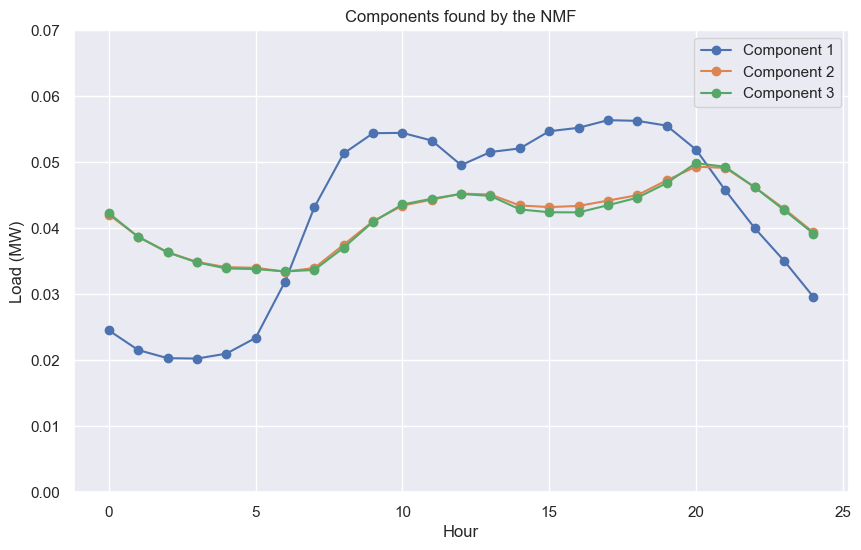

In [272]:
# Optimal run regarding minimum of distance to the consumption data
best_run = 3354

H = H_results[..., best_run]
W = W_results[..., best_run]
fig, ax = plot_components(H)
ylim = ax.set_ylim((0, 0.07))

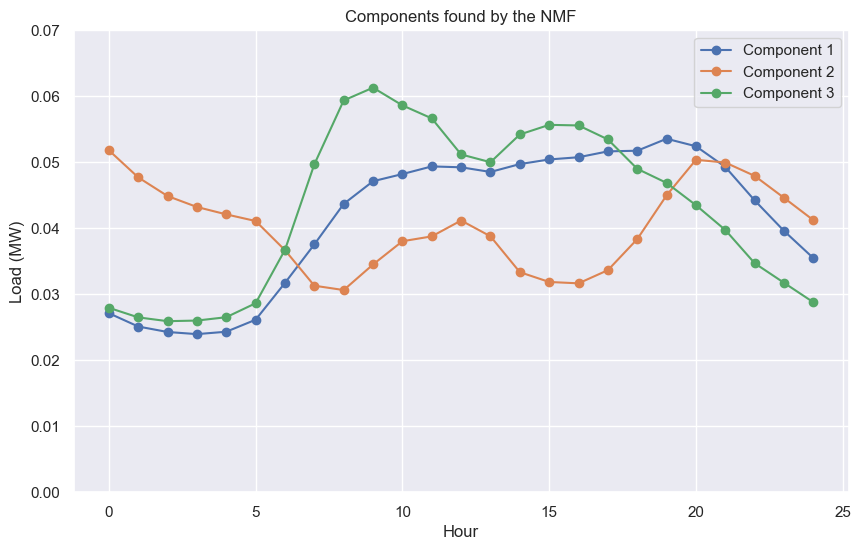

In [141]:
# Optimal run regarding minimum of distance to the simplex
best_run = 238

H = H_results[..., best_run]
W = W_results[..., best_run]
fig, ax = plot_components(H)
ylim = ax.set_ylim((0, 0.07))

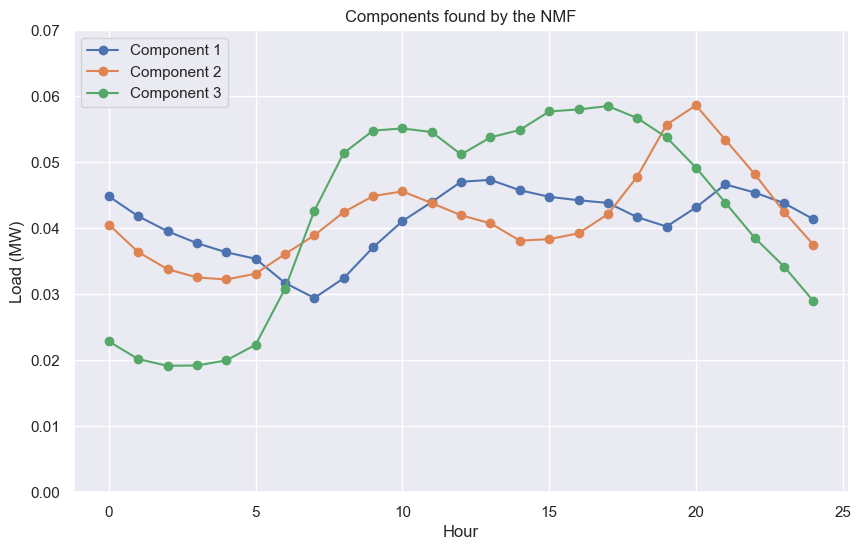

In [275]:
# Optimal run regarding the correlation with the indicators
best_run = 7544

H = H_results[..., best_run]
W = W_results[..., best_run]
fig, ax = plot_components(H)
ylim = ax.set_ylim((0, 0.07))

# Analysis of the solution

In [ ]:
# Compare the reconstructed consumption per sector with true consumption
year_cons = pd.DataFrame(cons[..., best_run], index=region_cons_df.index, columns=region_cons_df.columns)

In [ ]:
zone = 'Calabria'
cons_est = year_cons.loc[zone] / 1000
cons_true = region_cons_df.loc[zone] / 1000

fig, axs = plt.subplots(1, 2, figsize=(12,6), sharey=True, )
bar_est = cons_est.plot.bar(stacked=True, ax=axs[0], title='Estimated with Source Separation', ylabel='Consumption [TWh]', xlabel='')
bar_true = cons_true.plot.bar(stacked=True, ax=axs[1], title='Measured', xlabel='')

for ax in axs:
    ax.tick_params(axis='x', rotation=0)
    ax.set_ylim((0, 1.03 * ax.get_ylim()[1]))
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=3)
    # Annotate bars with their values for the first plot
    for container in ax.containers:
        ax.bar_label(container, label_type='center', fmt='{:.1f}', color='white', fontstyle='italic')

fig.suptitle(f'Consumption in {zone} bidding zone')
plt.savefig('plots/cons_est_vs_true/{}.png'.format(zone))
plt.show()

In [359]:
W = pd.DataFrame(W, index=df.index, columns=[f"Component {k+1}" for k in range(n_components)])
W[unit_info.columns] = df[unit_info.columns]
W['season'] = W.month.astype(int).map(month_to_season)
W

,Component 1,Component 2,Component 3,Component 4,Component 5,region,year,month,daytype,season
Italy_2018-01-01_Holiday,0.089544,0.000867,0.231812,0.496116,0.180032,Italy,2018,01,Holiday,Winter
Italy_2018-01-02_Working day,0.000029,0.275497,0.044633,0.466991,0.213210,Italy,2018,01,Working day,Winter
Italy_2018-01-03_Working day,0.116660,0.222472,0.017226,0.419347,0.221100,Italy,2018,01,Working day,Winter
Italy_2018-01-04_Working day,0.150560,0.209524,0.032514,0.401099,0.202286,Italy,2018,01,Working day,Winter
Italy_2018-01-05_Working day,0.163298,0.199787,0.020372,0.389701,0.222835,Italy,2018,01,Working day,Winter
...,...,...,...,...,...,...,...,...,...,...
Italy_2022-12-27_Working day,0.108290,0.256106,0.074984,0.348635,0.208464,Italy,2022,12,Working day,Winter
Italy_2022-12-28_Working day,0.158205,0.231186,0.039659,0.368422,0.198557,Italy,2022,12,Working day,Winter
Italy_2022-12-29_Working day,0.197545,0.209370,0.055222,0.348121,0.184582,Italy,2022,12,Working day,Winter
Italy_2022-12-30_Working day,0.171674,0.217404,0.082477,0.356153,0.168861,Italy,2022,12,Working day,Winter


In [ ]:
# W[(W.region == 'North')&(W.daytype == 'Working day')].sort_index().tail(20)

In [ ]:
W_region = W.groupby('region')[[f"Component {k+1}" for k in range(n_components)]].sum()
W_region = W_region.div(W_region.sum(axis=1), axis=0)
W_region

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
W_region.plot.barh(stacked=True, ax=ax)
ax.set_ylabel("")

<Axes: xlabel='component', ylabel='concentration'>

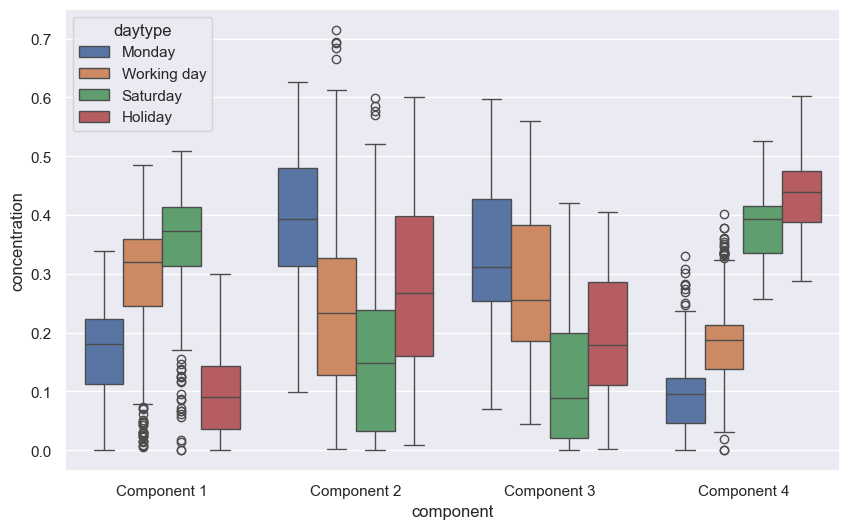

In [316]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='component',
    y='concentration',
    hue='daytype',
    hue_order=daytype_order
)

<Axes: xlabel='month', ylabel='concentration'>

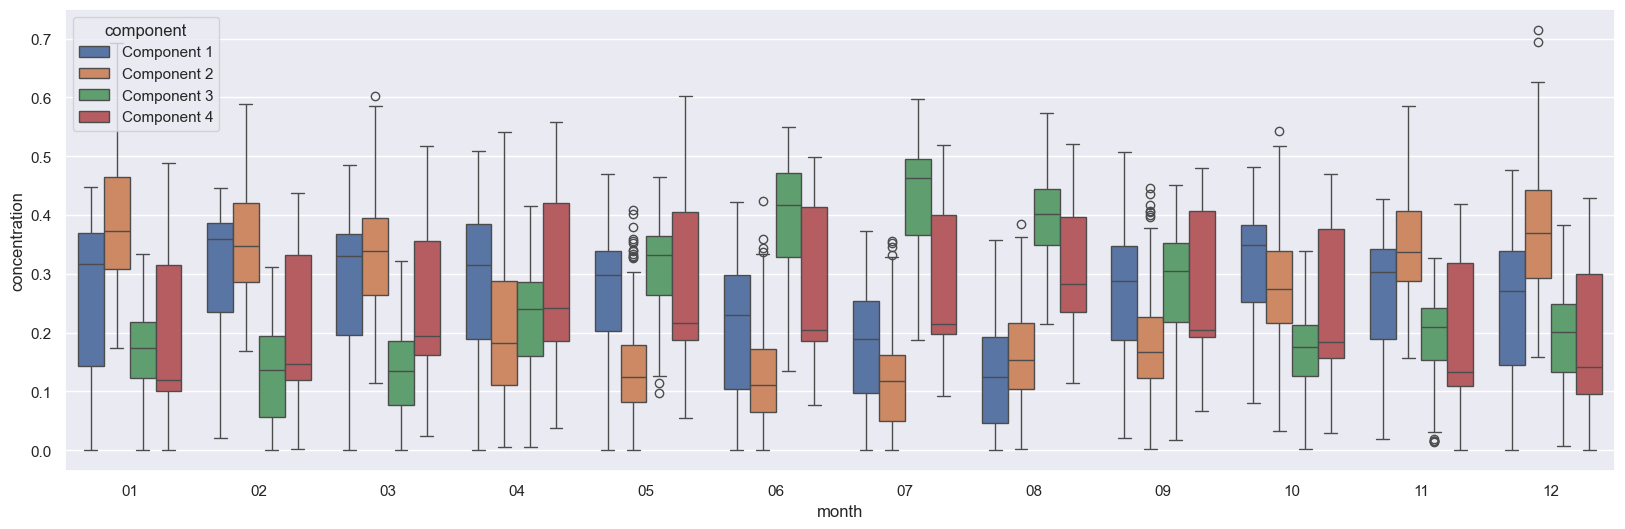

In [317]:
plt.figure(figsize=(20,6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
)

<Axes: xlabel='month', ylabel='concentration'>

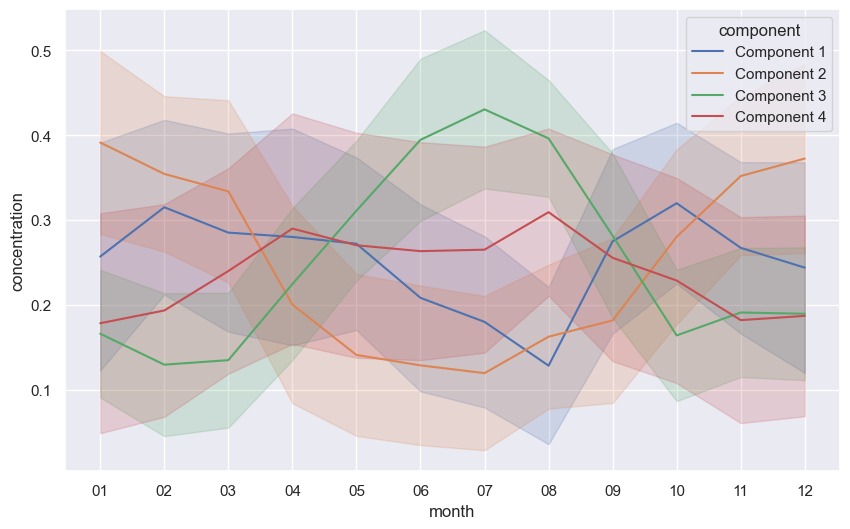

In [318]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
    errorbar='sd'
)

In [360]:
dimensions = [f'Component {k+1}' for k in range(n_components)]
height, width = 1000, 1100

fig = px.scatter_matrix(W, dimensions=dimensions, hover_name=W.index, color='daytype')
fig.update_layout(height=height, width=width)
fig.update_traces(selected=dict(marker=dict(color='yellow')))
fig.show()

In [361]:
dimensions = [f'Component {k+1}' for k in range(n_components)]
height, width = 1000, 1100

fig = px.scatter_matrix(W, dimensions=dimensions, hover_name=W.index, color='season')
fig.update_layout(height=height, width=width)
fig.update_traces(selected=dict(marker=dict(color='yellow')))
fig.show()

## Save results

In [358]:
opt = 'simp'
if smoothed:
    outfile = f'data/3_output/nmf_results/WHopt{opt}_{n_components}comp_smoothed_{n_runs}runs.npz'
else:
    outfile = f'data/3_output/nmf_results/WHopt{opt}_{n_components}comp_{n_runs}runs{specific}.npz'
np.savez(outfile, W=W, H=H)
print("Saved results at", outfile)

Saved results at data/3_output/nmf_results/WHoptsimp_5comp_1000runs_Italy.npz


___

# TESTS

In [ ]:
# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=dist_to_cons,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of squared distance of concentration vectors to the simplex',
    yaxis_title='Absolute distance to consumption data',
    title='Interaction between the criteria for mathematical and consumption solutions',
    height=800,
    width=1000,
    font=dict(
        size=16,  # Adjust font size here
    )
)

# # Show the plot
# fig.show()

In [139]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=H_sum_dist_unit,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex for W',
    yaxis_title='Sum of distance to simplex for H',
    title='Compliance of solutions with physics of the system and approximation quality',
    height=800,
    width=1000
)


In [140]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=errors,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex for W',
    yaxis_title='Sum of distance to simplex for H',
    title='Compliance of solutions with physics of the system and approximation quality',
    height=800,
    width=1000
)
